In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime, minimize_scalar

In [2]:
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
np.set_printoptions(precision=2)

In [4]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33

def lamba_metric(M, R):
    return -np.log((1-2*G*M/(c**2*R)))

def df_to_ep(df):
    e_den = df.energy_densityc2
    p_arr = df.pressurec2
    p = p_arr[p_arr > 1e8]
    e_den = e_den[p_arr > 1e8]
    e_den = e_den*((2.99792458e10)**2)
    pressure = p*((2.99792458e10)**2)
    return e_den.to_numpy(), pressure.to_numpy()
def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value= "extrapolate", kind = "cubic")
    return f_e_smooth
def get_pe(p, e):
    f_e_smooth = interp1d(e, p, fill_value=(0, 0), kind = "cubic", bounds_error=True)
    return f_e_smooth


path = "2205.02081/SLY4.csv"
df = pd.read_csv(path)
e_arr, p_arr = df_to_ep(df)
e, p = df_to_ep(df)
p_max = max(p)
p_min = max(1*(c**2), min(p)) 
EOS = get_ep(e, p)

In [5]:
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))
def _b(r, M):
    return (G*M)/((c**2)*r)
def _dnudr(r, Q, lamda):
    return (2/r) * np.exp(lamda) * Q
def _Q(r, P, M):
    frac = (4 * np.pi * G * (r**2)*P)/(c**4)
    return _b(r, M) + frac
def _dPdr(r, P, M, e):    
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return -1 * (e+P) * G/(c**2) * num/dem
def dedP_helper(p, e):
    return np.gradient(e, p), e
def dedP(p, e):
    dedp_helper, e_arr = dedP_helper(p, e)
    return interp1d(e_arr, dedp_helper, fill_value="extrapolate", kind = "cubic")
def drhodP(e, dedp = dedP(p, e)):
    return (c**-2) * dedp(e)

In [6]:
# DIMENSIONS CHECKED
def _H0(r, nu, X, nl, Q, omega, lamda, H1, b, K):
    omgr2_c2 = ((omega * r)**2)/(c**2)
    factor = (2*b + nl + Q) ** (-1)
    term1 = 8 * np.pi * (r**2) * np.exp(-nu/2) * X * (G/(c**4))
    term2 = - H1 * (Q*(nl+1) - omgr2_c2 * np.exp(-nu-lamda))
    term3 = K * (nl - omgr2_c2*np.exp(-nu)-Q*(np.exp(lamda)*Q-1))
    return factor * (term1 + term2 + term3)

# DIMENSIONS CHECKED
def _V(r, X, e, p, Q, nu, lamda, W, H0, omega):
    factor = np.exp(nu/2) * (c**2)/(omega**2)
    term1 = X/(e+p)
    term2 = -Q/(r**2) * W * np.exp((nu+lamda)/2)
    term3 = -np.exp(nu/2)*H0/2
    return factor * (term1 + term2 + term3)

In [8]:
## arXiv 2205.02081 ##
# DIMENSIONS CHECKED
def _dH1dr(r, l, b, lamda, p, e, H1, H0, K, V):
    G_c4 = G/(c**4)
    term1 = -H1*(l + 1 + 2*b*np.exp(lamda) + G_c4 * 4*np.pi*(r**2)*np.exp(lamda)*(p-e))
    term2 = np.exp(lamda) * (H0 + K - G_c4*16*np.pi*(e+p)*V)
    return (1/r) * (term1 + term2)

# DIMENSIONS CHECKED
def _dKdr(r, H0, nl, H1, lamda, Q, l, K, e, p, W):
    term1 = H0
    term2 = (nl+1)*H1
    term3 = (np.exp(lamda)*Q-l-1)*K
    term4 = -8*np.pi*(e+p)*np.exp(lamda/2)*W*G/(c**4)
    return (1/r) * (term1 + term2 + term3 + term4)

# DIMENSIONS CHECKED
def _dWdR(r, W, l, lamda, V, e, p, X, cad2_inv, H0, K, nu):
    term1 = -(l+1)*(W+l*np.exp(lamda/2)*V)
    term2_fac = (r**2 * np.exp(lamda/2))
    term2_1 = (np.exp(-nu/2)*X*(c**2) * cad2_inv)/(e+p)
    term2_2 = H0/2
    term2_3 = K
    term2 = term2_fac * (term2_1 + term2_2 + term2_3)
    return (1/r) * (term1 + term2)

# DIMENSIONS CHECKED 2205.02081
def _dXdr(r, l, X, e, p, nu, lamda, Q, H0, omega, nl, H1, K, V, W, derivative_term):
    omgr2_c2 = ((omega * r)**2)/(c**2)
    G_c4 = G/(c**4)
    term1 = -l*X
    term2_fac = (e+p)*np.exp(nu/2)/2
    term2_1 = (1-np.exp(lamda)*Q)*H0
    term2_2 = H1 * (omgr2_c2*np.exp(-nu) + nl + 1)
    term2_3 = K * (3*np.exp(lamda)*Q - 1)
    term2_4 = -4 * (nl + 1) * np.exp(lamda) * Q * V/(r**2)
    term2_5_fac = -2*W
    term2_5_1 = np.exp(lamda/2 - nu)*(omega**2)/(c**2)  
    term2_5_2 = G_c4 * 4 * np.pi * (e+p) * np.exp(lamda/2)
    term2_5_3 = -(r**2) * derivative_term 
    term2_5 =  term2_5_fac * (term2_5_1 + term2_5_2 + term2_5_3)
    term2 = term2_fac * (term2_1 + term2_2 + term2_3 + term2_4 + term2_5)
    return (1/r) * (term1 + term2)

In [9]:
def derivative_term(r, dMdr, dPdr, m, P):
    pi = np.pi
    exp = np.exp
    sqrt = np.sqrt
    return G*(G*(dMdr*r - m)*(4*pi*P*r**3 + c**2*m) - 6*(-2*G*m + c**2*r)*(4*pi*P*r**3 + c**2*m) + 2*(-2*G*m + c**2*r)*(c**2*dMdr*r - c**2*m + 4*pi*r**3*(2*P + dPdr*r)))/(2*c**6*r**6*((-2*G*m + c**2*r)/(c**2*r))**(5/4))

In [10]:
def coupledTOV(r, VEC, init_params):
    P, M, nu, H1, K, W, X = VEC
    EOS, l, omega, p_min, p_max, nl = init_params
    if P <= p_min: 
        return None
    if P >= p_max:
        return None
    if 2*_b(r, M) >= 1:
        return None
    b = _b(r, M)
    lamda = np.log(1/(1-2*b))
    Q = _Q(r, P, M)
    e = EOS(P) 
    cad2_inv = drhodP(e)
    
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    
    derv_term = derivative_term(r, dMdr, dPdr, M, P)
    
    dnudr = _dnudr(r, Q, lamda)
    H0 = _H0(r, nu, X, nl, Q, omega, lamda, H1, b, K)
    V = _V(r, X, e, P, Q, nu, lamda, W, H0, omega)

    # arXiv 2205.02081
    dH1dr = _dH1dr(r, l, b, lamda, P, e, H1, H0, K, V)
    dKdr = _dKdr(r, H0, nl, H1, lamda, Q, l, K, e, P, W)
    dWdr = _dWdR(r, W, l, lamda, V, e, P, X, cad2_inv, H0, K, nu)
    dXdr = _dXdr(r, l, X, e, P, nu, lamda, Q, H0, omega, nl, H1, K, V, W, derv_term)
    
    ret = [dPdr, dMdr, dnudr, dH1dr, dKdr, dWdr, dXdr]
    return ret

In [11]:
def tov(EOS, init_VEC, r_i, p_min,p_max, omega,nl, progress = False, 
        l=2, n_iter_max = 20000):
    init_params = [EOS, l, omega, p_min, p_max, nl]
    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('VODE')
    r.set_initial_value(init_VEC, r_i)
    results = [init_VEC]
    r_list = [r_i]
    i = 0
    r_max = 20 * km2cm
    max_iter = n_iter_max
    dr = r_max/max_iter
    if progress:
        pbar = tqdm(total=max_iter)
    while r.successful() and (r.y[0] >= p_min):
        i+=1
        integral = r.integrate(r.t+dr)
#         print(r.successful())
        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
        if (r.y[0] < p_min):
            break
        if not r.successful():
            break
        results.append(integral)
        r_list.append(r.t+dr)
    if progress:
        pbar.close()
    
#     print("Integration, Pressure: ", r.successful(), (r.y[0] >= p_min))
    
    results = np.array(results, dtype = float)
    p, m, nu, h1, k, w, x = results.T
    r = np.array(r_list)
    return p, m, r, nu, h1, k, w, x

In [12]:
def initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0):
    # DIMENSIONS CHECKED
    e_c = e0
    p_c = p0
    X0_factor = (e_c + p_c) * np.exp(nu0/2)
    X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
    X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
    X0_term3 = K0/2
    X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
    H00 = K0
    H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))
    return X0, H00, H10

def initial_conditions(EOS, e, p, k, km2cm = 1e5, r_i = 1, K0 = None):
    p0 = p[k]
    e0 = EOS(p0)
    p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
    e_c = EOS(p_c)
    m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
    omega = 1.931e3*(2*np.pi) #Arbitrary guess
    l=2 
    nl = (l-1)*(l+2)/2
    nu0 = -1 
    Q0 = _Q(r_i, p_c, m0)
    b0 = _b(r_i, m0)
    W0 = 1

    if K0 == None:
        K0 =  -(e_c + p_c) * (G/(c**4))
    
    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    p_max = max(p)
    p_min = max(c**2, min(p)) 
    return p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
    p_max, p_min, r_i, p0, e0

In [13]:
def surface_conditions(p, m, r_arr, nu, h1, k, w, x):
    max_idx = np.argmax(m) - 1
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    nu_R = nu[max_idx]
    h1_R = h1[max_idx]
    k_R = k[max_idx]
    w_R = w[max_idx]
    x_R = x[max_idx]
    schild = (1-2*G*m_R/(c**2*r_R))
    interior = np.exp(nu_R)
    return max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, interior

def print_params(p, m, r_arr, nu, h1, k, w, x):
    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
    print(f"Interior Surface: {interior:.8f}")
    print(f"Exterior Surface: {schild:.8f}")
    print(f"v0: {nu0}")
    print(f"Lamda: {lamba_metric(m_R, r_R)}")
    print(f"Boundary Term: {x_R}")
    return None

In [14]:
# p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
# p_max, p_min, r_i, p0, e0 = initial_conditions(EOS, e_arr, p_arr, -91)

p_c, e_c, m0, omega, l, nl, nu0, Q0, b0, W0, K0, X0, H00, H10, init_VEC, \
p_max, p_min, r_i, p0, e0 = initial_conditions(EOS, e, p, -27)

p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                           omega, nl, progress = True, l = l, 
                                   n_iter_max = 20000 * 10)

max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

print("== First Integration == ")
print_params(p, m, r_arr, nu, h1, k, w, x)

# Update init_VEC
nu_ext = -lamba_metric(m_R, r_R)
nu_int = nu_R #At surface
delta_nu = nu_int - nu_ext
nu0 =  nu0 - delta_nu

X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
time.sleep(0.2)

p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                           omega, nl, progress = True, l = l)

max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

print("== Second Integration == ")
print_params(p, m, r_arr, nu, h1, k, w, x)

# Update init_VEC
nu_ext = -lamba_metric(m_R, r_R)
nu_int = nu_R #At surface
delta_nu = nu_int - nu_ext
nu0 =  nu0 - delta_nu

X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
time.sleep(0.2)

p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                           omega, nl, progress = True, l = l)

max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

print("== Corrected Integration == ")
print_params(p, m, r_arr, nu, h1, k, w, x)


== First Integration == 
Star has mass 1.396 Msun and radius 11.464km
Interior Surface: 0.58707146
Exterior Surface: 0.64053406
v0: -1
Lamda: 0.44545298323446886
Boundary Term: 3.3949891209839444e+22



== Second Integration == 
Star has mass 1.396 Msun and radius 11.464km
Interior Surface: 0.64050586
Exterior Surface: 0.64053400
v0: -0.912844256589743
Lamda: 0.445453072168541
Boundary Term: 3.943284121300169e+22



== Corrected Integration == 
Star has mass 1.396 Msun and radius 11.464km
Interior Surface: 0.64053400
Exterior Surface: 0.64053400
v0: -0.9128003139370743
Lamda: 0.44545307011769825
Boundary Term: 3.9435671594201e+22


<IPython.core.display.Javascript object>


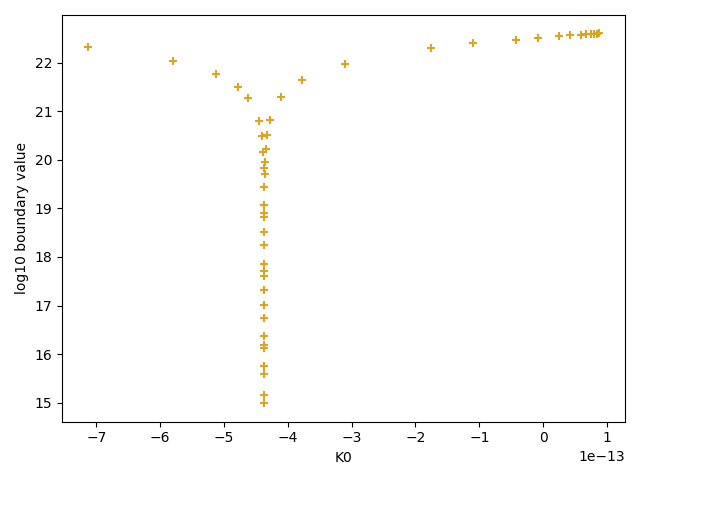

 final_simplex: (array([[-4.37e-13],
       [-4.37e-13]]), array([14.99, 15.16]))
           fun: 14.99070707630026
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 60
           nit: 30
        status: 2
       success: False
             x: array([-4.37e-13])

K0: -4.3670e-13


In [15]:
# Delete when shifting over to python
old_backend = mpl.get_backend() 
%matplotlib notebook 
# ====================================================================================
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
plt.xlabel("K0")
plt.ylabel("log10 boundary value")

def optimize_x_R(K0):
    
    # Update Initial Conditions in terms of K0    
    X0, H00, H10 = initial_conditions_helper(K0, e_c, p_c, nu0, omega, W0, nl, l, p0, e0)
    init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
    p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                                       omega, nl, progress = False, l = l, n_iter_max = 20000)
    max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
    interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
    loss = np.log10(abs(x_R))
    ax.scatter(K0, loss, color = "goldenrod", marker = "+")
    fig.canvas.draw()
    return loss

K0_guess = K0
init_guess = [K0_guess]
res = minimize(optimize_x_R, x0 = init_guess, method='Nelder-Mead', 
               options = {"disp": True, "maxiter":30, "fatol": 1e-20})

mpl.use(old_backend) # Delete when shifting over to python
display(res)
print(f"K0: {res.x[0]:.4e}")
K0 = res.x[0]
X0_factor = (e_c + p_c) * np.exp(nu0/2)
X0_term1 = 4 * np.pi/3 * (e_c + 3*p_c) * W0 * G/(c**4)
X0_term2 = -(omega**2)/l * np.exp(-nu0) * W0  /(c**2)
X0_term3 = K0/2
X0 = X0_factor * (X0_term1 + X0_term2 + X0_term3)
H00 = K0
H10 = (l*K0 + 8*np.pi*(G/(c**4))*(e_c+p_c)*W0)/((nl+1))

# for K0 in np.linspace(-1e-11, 1e-11, 100):
#     optimize_x_R(K0)

In [16]:
init_VEC = [p_c, m0, nu0, H10, K0, W0, X0]
time.sleep(0.2)

p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
                           omega, nl, progress = True, l = l)

max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)

print("== Corrected Integration == ")
print_params(p, m, r_arr, nu, h1, k, w, x)


== Corrected Integration == 
Star has mass 1.396 Msun and radius 11.464km
Interior Surface: 0.64053398
Exterior Surface: 0.64053411
v0: -0.9128003139370743
Lamda: 0.44545290618975697
Boundary Term: 966405077044106.5


In [17]:
# # Delete when shifting over to python
# old_backend = mpl.get_backend() 
# %matplotlib notebook 
# # ====================================================================================
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()
# fig.show()
# fig.canvas.draw()
# plt.xlabel("f-mode (Hz)")
# plt.ylabel("boundary value")

# def minimize_boundary_plot(params, p = p, EOS = EOS):
#     omega = params
#     p, m, r_arr, nu, h1, k, w, x = tov(EOS, init_VEC, r_i, p_min,p_max, 
#                                        omega, nl, progress = False, l = l, n_iter_max = 20000)
#     max_idx, m_R, r_R, p_R, ec_R, nu_R, h1_R, k_R, w_R, x_R, schild, \
#     interior = surface_conditions(p, m, r_arr, nu, h1, k, w, x)
#     loss = np.log10(abs(x_R))
#     ax.scatter(omega/(2*np.pi), loss, color = "dodgerblue", marker = "x")
#     fig.canvas.draw()
#     return loss

# omega_guess = (2*np.pi) * 2.4e3
# init_guess = [omega_guess]
# res = minimize(minimize_boundary_plot, x0 = init_guess, method='Nelder-Mead', 
#                options = {"disp": True, "maxiter":15})
# omg = res.x[0]
# omega = omg
# f = omg/(2*np.pi)
# mpl.use(old_backend) # Delete when shifting over to python
# display(res)
# print(f"fmode: {f:.2f} Hz")

In [18]:
# Zerilli equation helper functions
# Dimensions CHECKED
def g(r, m_R, nl):
    b = _b(r, m_R)
    n = nl
    num = n * (n+1) + 3*n*b + 6*(b**2)
    dem = (n + 3*b)
    return num/dem

# Dimensions CHECKED
def h(r, m_R, nl):
    b = _b(r, m_R)
    n = nl
    num = n - 3*n*b - 3*(b**2)
    dem = (1-2*b) * (n+3*b)
    return num/dem

# Dimensions CHECKED
def _k(r, m_R, nl):
    b = _b(r, m_R)
    n = nl
    return 1/(1-2*b)

K_R = k_R
num = h1_R - _k(r_R, m_R, nl) * K_R
dem = (h(r_R, m_R, nl) - _k(r_R, m_R, nl) * g(r_R, m_R, nl))
z_R = r_R*num/dem
dzdR_R = (K_R - g(r_R, m_R, nl)*z_R/r_R)
z0 = [z_R, dzdR_R] 
print(z0)

[-1.3733226768347598e-07, 1.5875573513092997e-13]


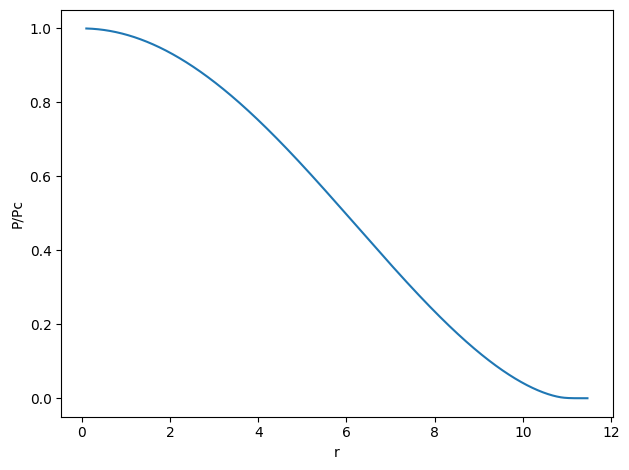

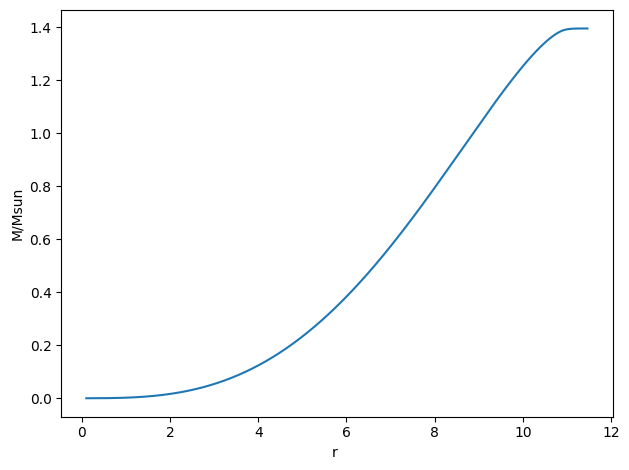

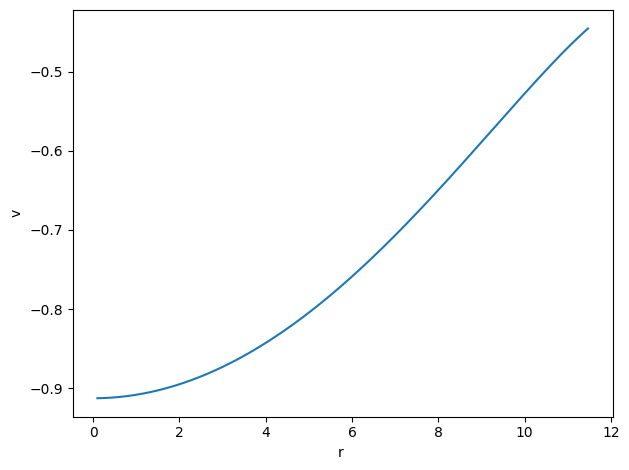

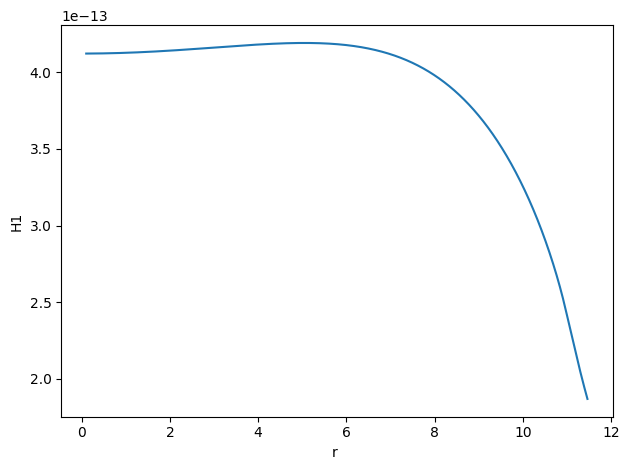

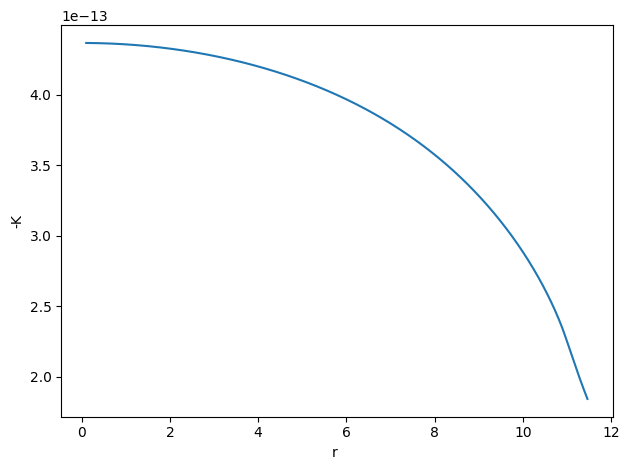

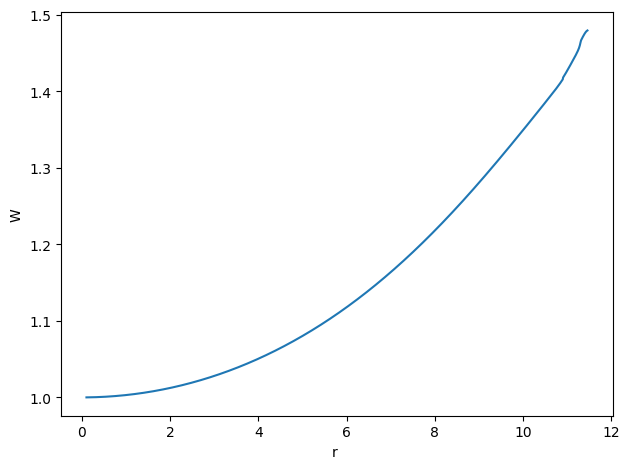

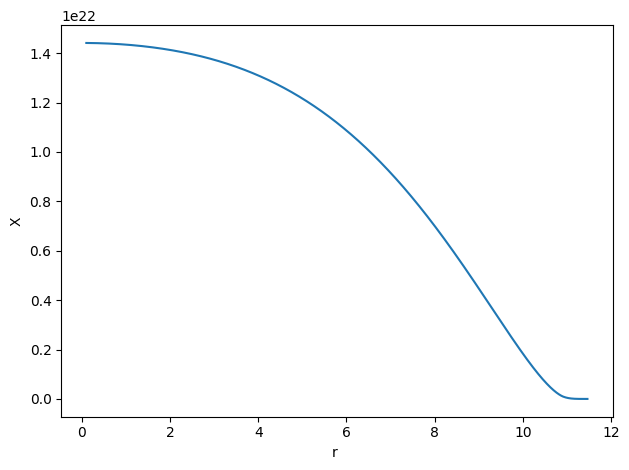

In [21]:
lims = 100

plt.figure()
plt.plot(r_arr[lims:]/km2cm, p[lims:]/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr[lims:]/km2cm, m[lims:]/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr[lims:]/km2cm, nu[lims:])
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

plt.figure()
plt.plot(r_arr[lims:]/km2cm, h1[lims:])
plt.xlabel("r ")
plt.ylabel("H1")
plt.show()

plt.figure()
plt.plot(r_arr[lims:]/km2cm, -k[lims:])
plt.xlabel("r ")
plt.ylabel("-K")
plt.show()

plt.figure()
plt.plot(r_arr[lims:]/km2cm, w[lims:])
plt.xlabel("r ")
plt.ylabel("W")
plt.show()

plt.figure()
plt.plot(r_arr[lims:]/km2cm, x[lims:])
plt.xlabel("r ")
plt.ylabel("X")
plt.show()

In [20]:
np.array([h1[0], -k[0], x[0], w[0]])

array([4.12e-13, 4.37e-13, 1.44e+22, 1.00e+00])